In [1]:
# Python version
from platform import python_version
print('Python version used in this Jupyter Notebook', python_version())

Python version used in this Jupyter Notebook 3.7.6


## Netflix Movies Recommendation System

## Installing and loading packages

In [2]:
# Installing watermark package
!pip install -q -U watermark

In [3]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb
from datetime import datetime

In [4]:
# Packages versions in this Jupyter Notebook
%reload_ext watermark
%watermark -a "Jupyter Notebook of DRGM" --iversions

Author: Jupyter Notebook of DRGM

scipy     : 1.4.1
numpy     : 1.21.6
sklearn   : 0.24.2
matplotlib: 3.4.2
xgboost   : 1.5.0
pandas    : 1.2.2



## Data Preparation

Let's work with samples of the data, otherwise Jupyter Notebook will take many hours to run.

In [59]:
# Function to get sparse matrix sample
def gera_amostra_matriz_esparsa(sparse_matrix, num_users, num_movies, path, verbose = True):
    
    # Tuple: (row, col) and (rating) of sparse matrix
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)
    
    # Random seed to reproduce the random process
    np.random.seed(15)
    
    # Users and movies samples
    sample_users = np.random.choice(users, num_users, replace = True)
    sample_movies = np.random.choice(movies, num_movies, replace = True)
    
    # Generate boolean mask
    mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))
    
    # Sparse Matrix with the original matrix samples
    amostra_matriz_esparsa = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                               shape = (max(sample_users) + 1, max(sample_movies) + 1))
    
    # Saving
    print('Salvando em disco...')
    sparse.save_npz(path, amostra_matriz_esparsa)
    
    if verbose:
        print('Tarefa concluida! \n')
        
    return amostra_matriz_esparsa

### Generating training data sample

In [60]:
%%time

# Path containing the sparse training matrix generated previously
caminho_matriz_treino_original = 'dados/matriz_esparsa_treino.npz'

# Loading sparse matrix
matriz_esparsa_treino_loaded = sparse.load_npz(caminho_matriz_treino_original)
print('Matriz Original Carregada!')

# Path to save the sample
path = 'dados/amostra_matriz_esparsa_treino.npz'

# Getting ratings from 1000 users to 100 movies in the sparse training matrix
amostra_matriz_esparsa_treino = gera_amostra_matriz_esparsa(matriz_esparsa_treino_loaded,
                                                            num_users = 1000,
                                                            num_movies = 100,
                                                            path = path)

Matriz Original Carregada!
Salvando em disco...
Tarefa concluida! 

Wall time: 57.1 s


### Generating Sample Test Data

In [61]:
%%time

# Path containing the sparse training matrix generated previously
caminho_matriz_teste_original = 'dados/matriz_esparsa_teste.npz'

# Carregando a matriz de amostra, caso já exista
matriz_esparsa_teste_loaded = sparse.load_npz(caminho_matriz_teste_original)
print('Matriz Original Carregada!')

# Loading the sample matrix if it already exists
path = 'dados/amostra_matriz_esparsa_teste.npz'

# Getting ratings from 200 users to 20 movies in the sparse training matrix
amostra_matriz_esparsa_teste = gera_amostra_matriz_esparsa(matriz_esparsa_teste_loaded,
                                                           num_users = 200,
                                                           num_movies = 20,
                                                           path = path)

Matriz Original Carregada!
Salvando em disco...
Tarefa concluida! 

Wall time: 10.8 s


In [62]:
# Resume
print('Numero de avaliacoes na matriz com amostras de treino: {}'.format(amostra_matriz_esparsa_treino.count_nonzero()))
print('Numero de avaliacoes na matriz com amostras de teste: {}'.format(amostra_matriz_esparsa_teste.count_nonzero()))

Numero de avaliacoes na matriz com amostras de treino: 1421
Numero de avaliacoes na matriz com amostras de teste: 6


Samples created. Change the number of users and number of movies if you want to work with larger samples.

### Metrics Extracted from Data

Let's check some metrics from the data. Our model will predict the user rating of the movie.

In [63]:
# Create the dictionary
amostra_medias_treino = dict()

The function below will be used to calculate the average of ratings.

In [64]:
def calcula_media_ratings(sparse_matrix, of_users):
    
    # Média de avaliações
    # 1 representa o eixo de usuários
    # 0 representa o eixo de filmes
    ax = 1 if of_users else 0

    # Soma das avaliações
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1
    
    # Matriz booleana de avaliações (se um usuário avaliou ou não um filme)
    is_rated = sparse_matrix != 0
    
    # Número de avaliações de cada usuário ou filme
    no_of_ratings = is_rated.sum(axis = ax).A1
    
    # Ids da matriz esparsa, u de usuário (rows) e m de movie (columns)
    u, m = sparse_matrix.shape
    
    # Dicionário de usuários e suas avaliações
    average_ratings = {i: sum_of_ratings[i] / no_of_ratings[i]
                                         for i in range(u if of_users else m)
                                         if no_of_ratings[i] != 0}
    
    return average_ratings

Overall average of movie ratings:

In [65]:
# Overall average
media_global = amostra_matriz_esparsa_treino.sum() / amostra_matriz_esparsa_treino.count_nonzero()
amostra_medias_treino['global'] = media_global
amostra_medias_treino

{'global': 3.6030964109781842}

Average rating per user:

In [66]:
# Calculates average user rating
amostra_medias_treino['user'] = calcula_media_ratings(amostra_matriz_esparsa_treino, of_users = True)

In [67]:
# Let's extract one of the users from the movie dictionary (the goal here is just to automate the process)
um_usuario = [a for a, b in amostra_medias_treino['user'].items()][0]
um_usuario

4540

In [68]:
# Print
print('Media de Avaliacao do Usuario ' + str(um_usuario) + ':', amostra_medias_treino['user'][um_usuario])

Media de Avaliacao do Usuario 4540: 4.0


Average rating per movie:

In [69]:
# Calculates the average rating of movies
amostra_medias_treino['movie'] =  calcula_media_ratings(amostra_matriz_esparsa_treino, of_users = False)

In [70]:
# Let's extract one of the movies from the movie dictionary (the goal here is just to automate the process)
um_filme = [a for a, b in amostra_medias_treino['movie'].items()][0]
um_filme

130

In [71]:
# Print
print('Média de Avaliação do Filme ' + str(um_filme) + ':', amostra_medias_treino['movie'][um_filme])

Média de Avaliação do Filme 130: 2.0


## Formatting the Data

We will build a regression model, since we want to predict the evaluations (numerical values). Let's prepare the training and test data below.

These are the variables with which we will build the model:

Predictor Variables (input)::

- **GAvg** : Global average of evaluations


- **Rating from similar users**:
    - sur1, sur2, sur3, sur4, sur5 (top 5 users similar to each user who rated a movie)
    

- **Similar movies rated by a user**:
    - smr1, smr2, smr3, smr4, smr5 (Top 5 movies similar to each movie rated)


- **UAvg** : Average user ratings


- **MAvg** : Average movie rating


Target Variable (output):

- **rating** : Rating of the movie given by a user

### Preparing Training Data for the Regression Model

In [72]:
# Extracting data from the sample matrix
amostra_usuarios_treino, amostra_filmes_treino, amostra_avaliacoes_treino = sparse.find(amostra_matriz_esparsa_treino)

The cell below takes a long time to run.

In [73]:
%%time

# We check if the file already exists
if os.path.isfile('dados/dados_treino_reg.csv'):
    print("O arquivo já existe e não precisamos criar movamente..." )
else:
    print('Preparando {} tuplas para o dataset..\n'.format(len(amostra_medias_treino)))
    with open('dados/dados_treino_reg.csv', mode = 'w') as reg_data_file:
        count = 0
        for (user, movie, rating) in zip(amostra_usuarios_treino, amostra_filmes_treino, amostra_avaliacoes_treino):
             
            ###### Rating of a "movie" by users similar to the current user ######
            
            # Calculate user similar to current user        
            user_sim = cosine_similarity(amostra_matriz_esparsa_treino[user], 
                                         amostra_matriz_esparsa_treino).ravel()
            
            # Get top users
            top_sim_users = user_sim.argsort()[::-1][1:] 
            
            # Get reviews from similar users
            top_ratings = amostra_matriz_esparsa_treino[top_sim_users, movie].toarray().ravel()
            
            # Top similar users up to 5
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([amostra_medias_treino['movie'][movie]]*(5 - len(top_sim_users_ratings))) 

            ##### User ratings for movies similar to the current movie #####
            
            # Calculates films similar to the current film       
            movie_sim = cosine_similarity(amostra_matriz_esparsa_treino[:,movie].T, 
                                          amostra_matriz_esparsa_treino.T).ravel()
            
            # Top movies
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            
            # Get ratings of the most similar movie for the current user
            top_ratings = amostra_matriz_esparsa_treino[user, top_sim_movies].toarray().ravel()
            
            # Top similar users up to 5
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([amostra_medias_treino['user'][user]] * (5-len(top_sim_movies_ratings))) 

            ##### Prepare the line to be stored in the file #####
            row = list()
            row.append(user)
            row.append(movie)
            
            # We added other attributes 
            row.append(amostra_medias_treino['global']) 
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            row.append(amostra_medias_treino['user'][user])
            row.append(amostra_medias_treino['movie'][movie])

            row.append(rating)
            count = count + 1
            
            #if count == 10:
            #    break

            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                print("Concluído para {} linhas----- {}".format(count, datetime.now() - start))

Preparando 3 tuplas para o dataset..

Wall time: 4min 36s


We load the file and place it in a dataframe.

In [74]:
df_dados_treino_reg = pd.read_csv('dados/dados_treino_reg.csv', 
                               names = ['user', 
                                        'movie', 
                                        'GAvg', 
                                        'sur1', 
                                        'sur2', 
                                        'sur3', 
                                        'sur4', 
                                        'sur5',
                                        'smr1', 
                                        'smr2', 
                                        'smr3', 
                                        'smr4', 
                                        'smr5', 
                                        'UAvg', 
                                        'MAvg', 
                                        'rating'], 
                               header = None)

In [75]:
# Data
df_dados_treino_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,2305904,130,3.603096,2.0,2.0,2.000000,2.000000,2.000000,5.0,3.5,3.5,3.5,3.5,3.500000,2.000000,2
1,662124,429,3.603096,2.0,2.0,2.666667,2.666667,2.666667,5.0,4.0,5.0,3.0,3.0,3.733333,2.666667,4
2,1364103,429,3.603096,2.0,4.0,2.666667,2.666667,2.666667,2.0,5.0,5.0,1.0,4.0,3.100000,2.666667,2
3,2475820,429,3.603096,4.0,2.0,2.666667,2.666667,2.666667,3.0,4.0,4.0,4.0,4.0,3.550000,2.666667,2
4,857031,917,3.603096,5.0,5.0,5.000000,5.000000,5.000000,3.0,4.0,4.0,4.0,4.0,4.000000,5.000000,5


### Preparing Test Data for the Regression Model

The process here is the same as what we did with training data.

In [76]:
# Extracting data from the sample matrix
amostra_usuarios_teste, amostra_filmes_teste, amostra_avaliacoes_teste = sparse.find(amostra_matriz_esparsa_teste)

In [77]:
%%time

if os.path.isfile('dados/dados_teste.reg.csv'):
    print('O arquivo ja existe e nao precisamos criar novamente...')
else:
    
    print('Preparando {} tuplas para o dataset...\n'.format(len(amostra_avaliacoes_teste)))
    with open('dados/dados_teste_reg.csv', mode = 'w') as reg_data_file:
        count = 0
        for (user, movie, rating) in zip(amostra_usuarios_teste, amostra_filmes_teste, amostra_avaliacoes_teste):
            st = datetime.now()

            # Similarity of users
            try:
                user_sim = cosine_similarity(amostra_matriz_esparsa_treino[user],
                                             amostra_matriz_esparsa_treino).ravel()
                
                top_sim_users = user_sim.argsort()[::-1][1:]
                top_ratings = amostra_matriz_esparsa_treino[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([amostra_medias_treino['movie'][movie]] * (5 - len(top_sim_users_ratings)))
            
            except(IndexError, KeyError):
                top_sim_users_ratings.extend([amostra_medias_treino['global']] * (5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                raise
                
            # Similarity of movies
            try:
                movie_sim = cosine_similarity(amostra_matriz_esparsa_treino[:, movie].T,
                                              amostra_matriz_esparsa_treino.T).ravel()
                
                top_sim_movies = movie_sim.argsort()[::-1][1:]
                top_ratings = amostra_matriz_esparsa_treino[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([amostra_medias_treino['user'][user]] * (5 - len(top_sim_users_ratings)))
            except (IndexError, KeyError):
                top_sim_users_ratings.extend([amostra_medias_treino['global']] * (5 - len(top_sim_movies_ratings)))
            except:
                raise

            # Prepare data to write to file
            row = list()
            row.append(user)
            row.append(movie)
            row.append(amostra_medias_treino['global'])
            row.extend(top_sim_users_ratings)
            row.extend(top_sim_movies_ratings)
            
            try:
                row.append(amostra_medias_treino['user'][user])
            except KeyError:
                row.append(amostra_medias_treino['global'])
            except:
                raise
                
            row.append(rating)
            
            count = count + 1
            
            #if count == 5:
            #    break
            
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count) % 1000 == 0:
                print('Concluido em {} linhas------{}'.format(count, datetime.now() - start))            

Preparando 6 tuplas para o dataset...

Wall time: 1.06 s


We load the file and place it in a dataframe.

In [78]:
# Generate the test dataset
df_dados_teste_reg = pd.read_csv('dados/dados_teste_reg.csv', names = ['user',
                                                                       'movie',
                                                                       'GAvg',
                                                                       'sur1',
                                                                       'sur2',
                                                                       'sur3',
                                                                       'sur4',
                                                                       'sur5',
                                                                       'smr1',
                                                                       'smr2',
                                                                       'smr3',
                                                                       'smr4',
                                                                       'smr5',
                                                                       'UAvg',
                                                                       'MAvg',
                                                                       'rating'],
                                header = None)

In [79]:
df_dados_teste_reg.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1667387,1833,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,4,NaN
1,163650,3835,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,4,NaN
2,1154263,3835,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3,NaN
3,1637793,3835,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3,NaN
4,1920310,3835,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,3.603096,2,NaN


## Building the Machine Learning Model

The last step of the work is to build, train and evaluate the model.

In [91]:
# Dictionaries for model evaluation
models_evaluation_train = dict()
models_evaluation_test = dict()

Below are some functions to run the model.

In [81]:
# Function for calculating the model error
def calcula_metricas(y_true, y_pred):
    rmse = np.sqrt(np.mean([(y_true[i] - y_pred[i]) **2 for i in range(len(y_pred))]))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mape

In [82]:
# Function for training and testing the model
def executa_modelo_xgboost(modelo, x_train, y_train, x_test, y_test, verbose = True):

    # Dicionários
    train_results = dict()
    test_results = dict()
    
    # Training model
    print('Treinando o modelo..')
    start = datetime.now()
    modelo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Concluído. Tempo total: {}\n'.format(datetime.now() - start))

    # Calculating model error on training data
    print('Calculando as Métricas com Dados de Treino.')
    start = datetime.now()
    y_train_pred = modelo.predict(x_train)
    rmse_train, mape_train = calcula_metricas(y_train.values, y_train_pred)
    
    # Save the results
    train_results = {'rmse': rmse_train, 'mape' : mape_train, 'previsoes' : y_train_pred}
    
    if verbose:
        print('\nErro do Modelo em Dados de Treino')
        print('-'*30)
        print('RMSE (Train): ', rmse_train)
        print('MAPE (Train): ', mape_train)
        
    # Evaluating the model with test data
    print('\nAvaliando o modelo com dados de teste.')
    y_test_pred = modelo.predict(x_test) 
    rmse_test, mape_test = calcula_metricas(y_true = y_test.values, y_pred = y_test_pred)
    
    # Save the results
    test_results = {'rmse': rmse_test, 'mape' : mape_test, 'previsoes':y_test_pred}
    
    if verbose:
        print('\nErro do Modelo em Dados de Teste')
        print('-'*30)
        print('RMSE (Test): ', rmse_test)
        print('MAPE (Test): ', mape_test)
        
    return train_results, test_results

In [83]:
# Seed
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

## Training the model

In [84]:
# Prepare training data
x_treino = df_dados_treino_reg.drop(['user', 'movie', 'rating'], axis = 1)
y_treino = df_dados_treino_reg['rating']

In [85]:
# Prepare test data
x_teste = df_dados_teste_reg.drop(['user', 'movie', 'rating'], axis = 1)
y_teste = df_dados_teste_reg['rating']

In [86]:
# Creates the regression model with 100 estimators
modelo_xgb = xgb.XGBRegressor(silent = False, random_state = my_seed, n_estimators = 100)

In [87]:
# Training the model
train_results, test_results = executa_modelo_xgboost(modelo_xgb, x_treino, y_treino, x_teste, y_teste)

Treinando o modelo..
[16:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Concluído. Tempo total: 0:00:00.122469

Calculando as Métricas com Dados de Treino.

Erro do Modelo em Dados de Treino
------------------------------
RMSE (Train):  0.052987308251704945
MAPE (Train):  1.1448104552699176

Avaliando o modelo com dados de teste.

Erro do Modelo em Dados de Teste
------------------------------
RMSE (Test):  nan
MAPE (Test):  nan


In [92]:
# Stores model evaluation results
models_evaluation_train['modelo_xgb'] = train_results
models_evaluation_test['modelo_xgb'] = test_results

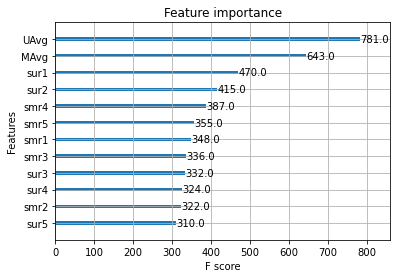

In [95]:
# Most important variables for the model
xgb.plot_importance(modelo_xgb)
plt.show()

In addition to building the model, we also identify the most relevant variables. Note that there is no surprise. User ratings are crucial for recommending rated movies to other users.

## Saving the results

In [96]:
# Save results
pd.DataFrame(models_evaluation_test).to_csv('dados/resultado.csv')
models = pd.read_csv('dados/resultado.csv', index_col = 0)
models.loc['rmse'].sort_values()

modelo_xgb    NaN
Name: rmse, dtype: object